

#  Image Alignment using Homography  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1J6z4CvhrfaSn6wbyiMIIl5A2uE3aLymB?usp=sharing)

In this notebook, we explore how to align a scanned image with its original version using a technique called **homography**.

Homography helps us map points from one image to another — especially useful when the image has been taken from a different angle or has some perspective distortion (like a photo of a document).

We’ll go step by step:
- Detect key features using ORB
- Match those features between the original and scanned images
- Compute a homography matrix
- Use it to **warp** the scanned image so it lines up with the original

By the end, you’ll see how a distorted scan gets transformed to perfectly match its reference — a core idea behind tasks like document scanning, panorama stitching, and AR overlays.

No deep math — just visual learning and working code.




##Importing Libraries

In [1]:
#Importation of Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


##Step 1 : Load the Original and Scanned Images



In [ ]:

#Reading the image
original_img="form.jpg"

#Reading in color and convertion from bgr to rgb
im1=cv2.imread(original_img,cv2.IMREAD_COLOR)
im1=cv2.cvtColor(im1,cv2.COLOR_BGR2RGB)

#Image to be aligned
scanned_img='scanned-form.jpg'
im2=cv2.imread(scanned_img,cv2.IMREAD_COLOR)
im2=cv2.cvtColor(im2,cv2.COLOR_BGR2RGB)



## Step 2: Visualizing the Images

To verify both images before alignment, we display them side by side. This helps compare the reference image with the scanned one visually.

- The large figure size ensures details are visible.
- Side-by-side subplots offer an instant look at distortions or misalignments.
- This step doesn’t affect the algorithm but is crucial for visual debugging and clarity.


Text(0.5, 1.0, 'Scanned Image')

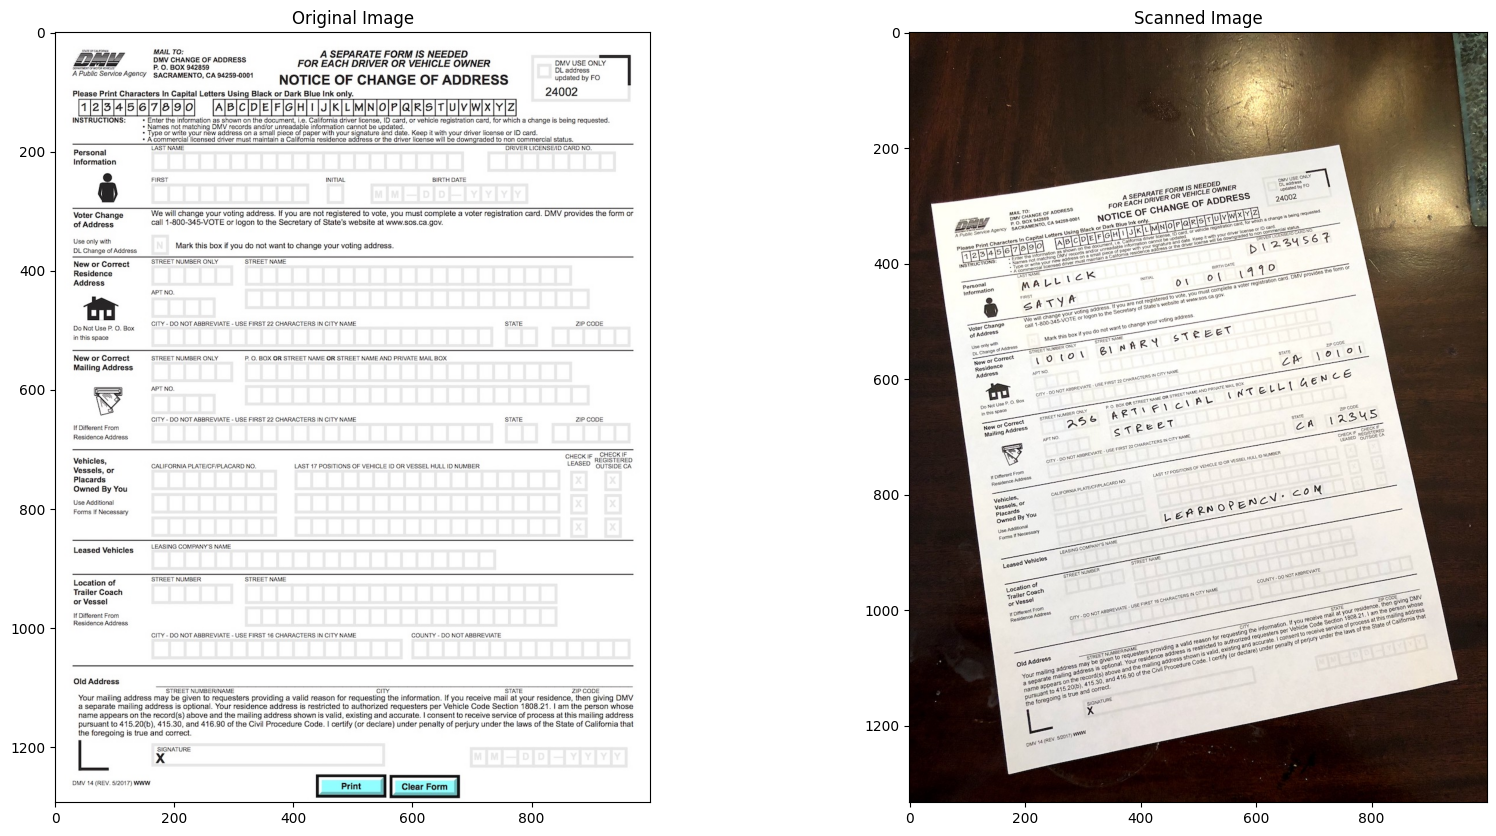

In [ ]:
#Displaying
plt.figure(figsize=[20,10]);

plt.subplot(121);plt.imshow(im1);plt.title("Original Image")
plt.subplot(122);plt.imshow(im2);plt.title("Scanned Image")


##  Step 3: Keypoint Detection Using ORB (Oriented FAST and Rotated BRIEF)

To align two images, we first need to **identify key points** — distinct features like corners or blobs that can be matched between images.

###  Why Grayscale?

- Keypoint detection works on intensity patterns, not color.
- Converting to grayscale simplifies data and speeds up processing.

###  Feature Detection Using ORB

- **ORB** is a fast and efficient algorithm combining:
  - **FAST** (for detecting keypoints)
  - **BRIEF** (for generating descriptors)
- Setting `MAX_NUM_FEATURES = 500` limits the number of points detected, balancing performance and sensitivity.

>  *Are there other detection methods like ORB?*  
Yes — here are a few alternatives:
- `SIFT` (Scale-Invariant Feature Transform): very robust but patented (requires OpenCV contrib).
- `SURF`: Faster than SIFT but still under patent.
- `AKAZE`: Open-source, good performance.
- `BRISK`: Binary descriptor like ORB but with different mechanics.


- detectAndCompute function **returns both** keypoints and descriptors:
  - `keypoints`: Visual positions (used for drawing or matching)
  - `descriptors`: Actual numeric vectors used to compare features between images




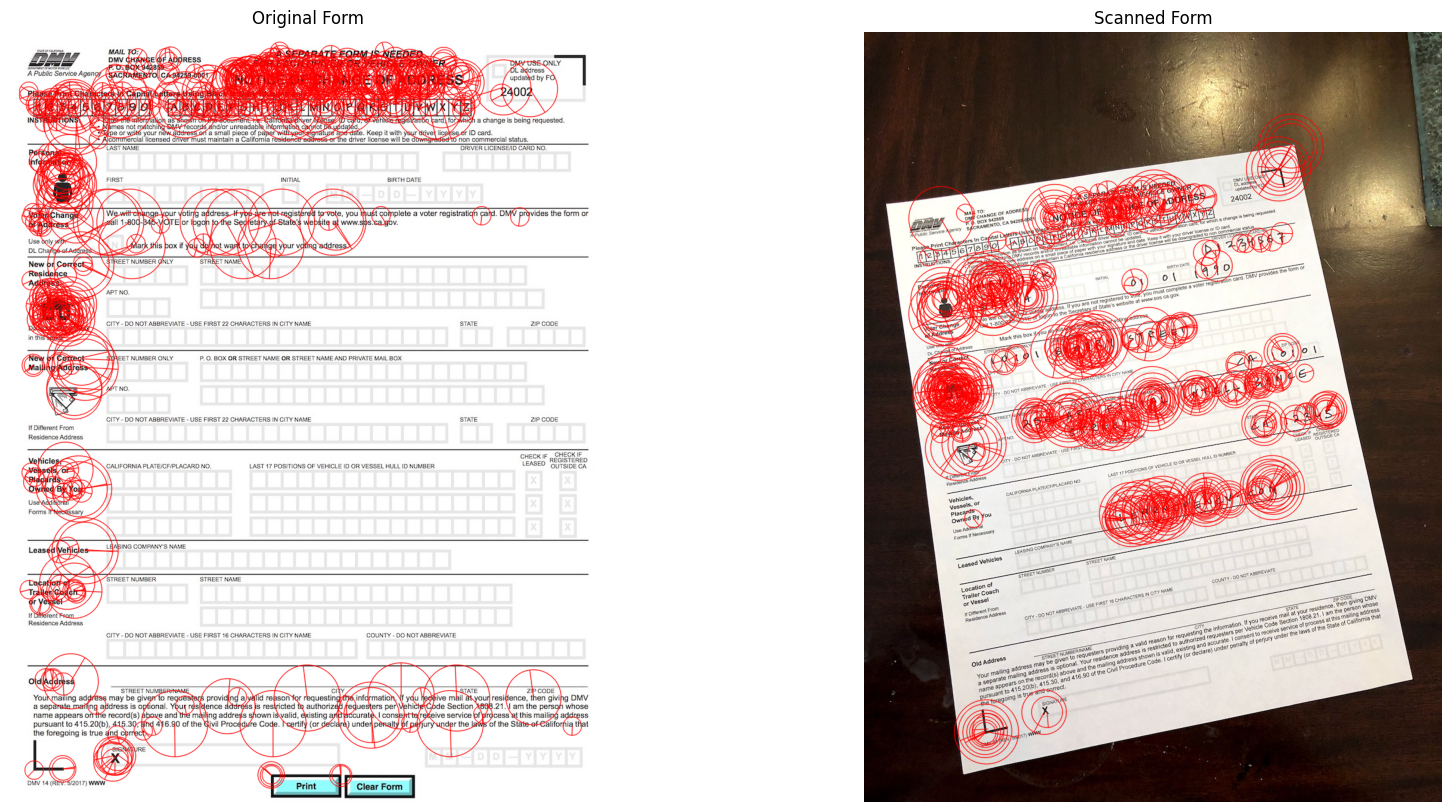

In [ ]:
#Changing the images into gray
im1_gray=cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray=cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

#Detection throug detecting orbs
MAX_NUM_FEATURES = 500 #More number of feature , more sensitivitity
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray,None) #This None argumenst is optional if theres MAsk in image, None means analyze full image
#Key points are just for visual display while desriptors are real array where things are happening
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");


##  Step 4: Matching Features Between the Two Images

After detecting features in both images, the next step is to **match descriptors** — this helps us find common patterns that appear in both versions of the form.

### 🧠 Descriptors, Not Keypoints, Are Compared

- **Keypoints** define "where" something is in the image.
- **Descriptors** define "what" that something looks like.
- The matcher compares only the **descriptors**, not the keypoint positions.

###  Matching Using Brute-Force + Hamming Distance

- `BRUTEFORCE_HAMMING` is used for binary descriptors like ORB.
- It directly compares each descriptor from one image to every descriptor in the other image, using **Hamming distance**.
  - Hamming distance = Number of bits that differ between two binary descriptors
  - Lower distance = **Better match**

### Sort by Distance?

- Sorting ensures that the **most similar matches come first**.
- We want to prioritize feature pairs that are more likely to correspond to the same point on the object.

### Filtering Factor
> “`matches = matches[:numGoodMatches]` — this just taking the first 10% with minimum distance.



In [ ]:
#Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#Match happes with only descriptor and not with keypoints
matches = list(matcher.match(descriptors1, descriptors2))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False) #The sorting by distance with matcher points

# Remove not so good matches
 #As we are sorting before by distance meaning min the distance better the mathch
numGoodMatches = int(len(matches) * 0.1) #0.1 factors lets to just choose the 1s t 10% of min distance match
matches = matches[:numGoodMatches]


###  How Hamming Matching Actually Works (Step-by-Step)

Let’s break it down with precision:

1. **You have two sets of descriptors**:
   - `descriptors1` → from the **reference/original image** (e.g., 500 descriptors)
   - `descriptors2` → from the **scanned/target image** (e.g., also 500 descriptors)

2. The matcher runs a brute-force comparison:
   - For **each descriptor** in `descriptors1` (reference image),
   - It computes the **Hamming distance** with **every single descriptor** in `descriptors2`.

3. From all those comparisons, it selects the one with the **shortest Hamming distance** — that’s the best match.

4. This process repeats for **every descriptor in the reference image**.

### But Here's the Catch — You Can Detect Bad Matches like matching Unlike images too.

1. **Match distance will be high**:
   - You’ll see most Hamming distances are **large**, meaning descriptors differ in many bits.
   - Sorting and plotting those distances will reveal **no cluster of good matches**.

2. **Visual match display will look random**:
   - If you draw lines between matched points using `cv2.drawMatches()`, they’ll crisscross randomly.
   - No structure, no alignment — just noise.

3. **Homography calculation will fail**:
   - If you try to estimate a transformation (like a warp), OpenCV’s `findHomography()` will return junk or `None`.

>  Matching does not guarantee semantic meaning. It's your job to filter or validate if those matches make sense.


##  Step 5: Visualizing the Matched Keypoints

Once the best matches are selected, we **draw lines** between matched keypoints in both images to visually verify how well they align.

###  Why This Matters

- A good match set will show lines **connecting the same physical points** (e.g., corners of a form or text regions).
- If the matches are poor or random:
  - Lines will **crisscross erratically**.
  - You'll immediately notice misalignment or noise in the matching.


> A clean and consistent match line pattern here usually means you're good to proceed with homography.


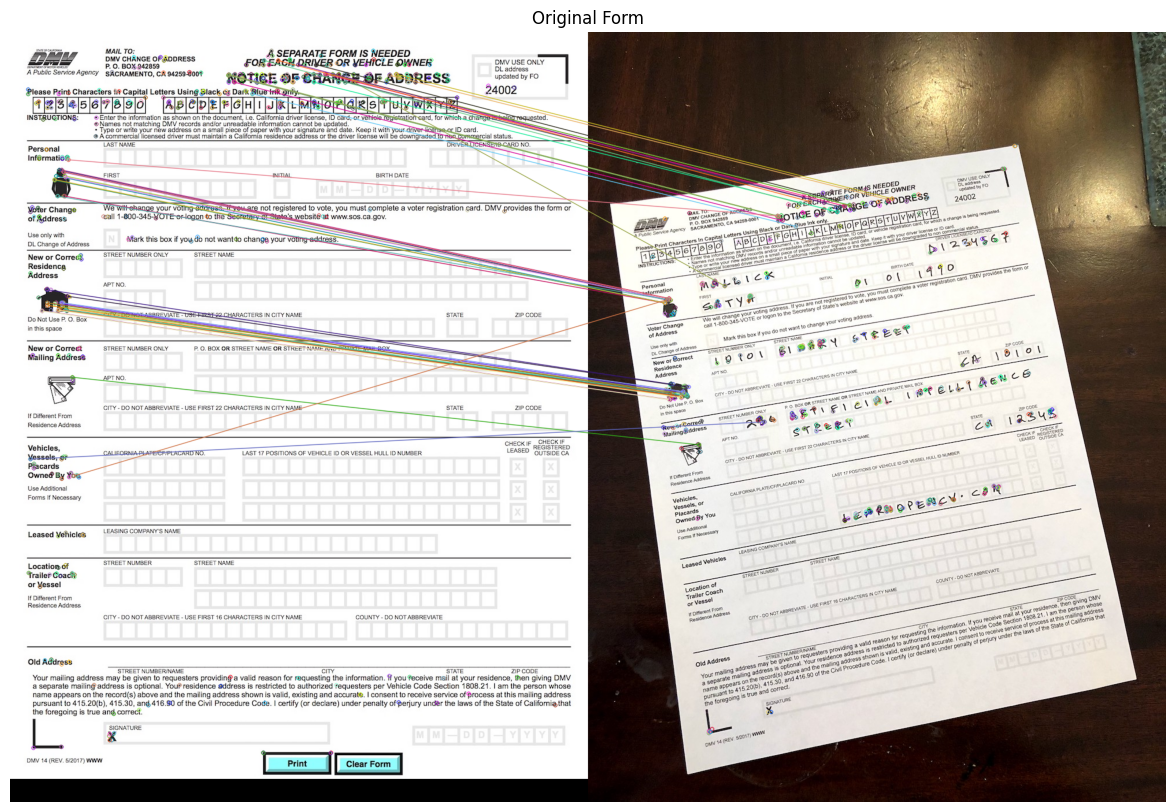

In [ ]:
# Draw top matches to see the distance and matching points
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form")

## Step 6: Computing the Homography Matrix

Now that we've identified **strong matching points** between both images, we can compute the transformation that aligns one image onto the other — this is done using **homography**.

###  What Is Homography?

A **homography matrix (3×3)** describes how to map points from one plane (image) to another — accounting for:
- Translation
- Rotation
- Scale
- Perspective distortion

This is especially useful when:
- The surface is flat (like a form or a book page).
- The camera captured it from a different angle.

### 🧠 Extracting Match Coordinates

- We extract the 2D coordinates (`.pt`) from the **keypoints** of the top matches.
- `queryIdx`: Index in the reference image
- `trainIdx`: Index in the target image

> This step gives us two sets of corresponding points that can now be used to compute the mapping.

### 🔧 `cv2.findHomography()`

- `cv2.findHomography(points2, points1, cv2.RANSAC)` returns:
  - `h`: The 3×3 **homography matrix**
  - `mask`: A binary mask indicating **which matches were considered inliers** (i.e., valid)
- **RANSAC** (RANdom SAmple Consensus) is used here to:
  - Handle outliers in the point matches
  - Make the homography estimation more robust

> Without RANSAC, even a few wrong matches could throw off the entire transformation.


In [ ]:
#USing the findHEmography algo
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints1[match.queryIdx].pt
  points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

##  Step 7: Warping the Image Using the Homography Matrix

With the homography matrix calculated, we now **warp the scanned image** to align it with the reference image.

###  `cv2.warpPerspective()`

- This function applies the **3×3 homography matrix** to transform the entire image.
- It bends, rotates, shifts, and scales the scanned image to match the original image’s perspective.
- The output size `(width, height)` is taken from the reference image to keep the dimensions consistent.

###  Visualizing the Final Alignment

- Displaying both images side by side helps confirm if the transformation worked.
- A successful warp should result in:
  - Aligned corners
  - Matching content layout
  - Similar orientation and perspective

> This step effectively corrects for skew or camera distortion — turning a misaligned scan into a properly aligned version of the original.


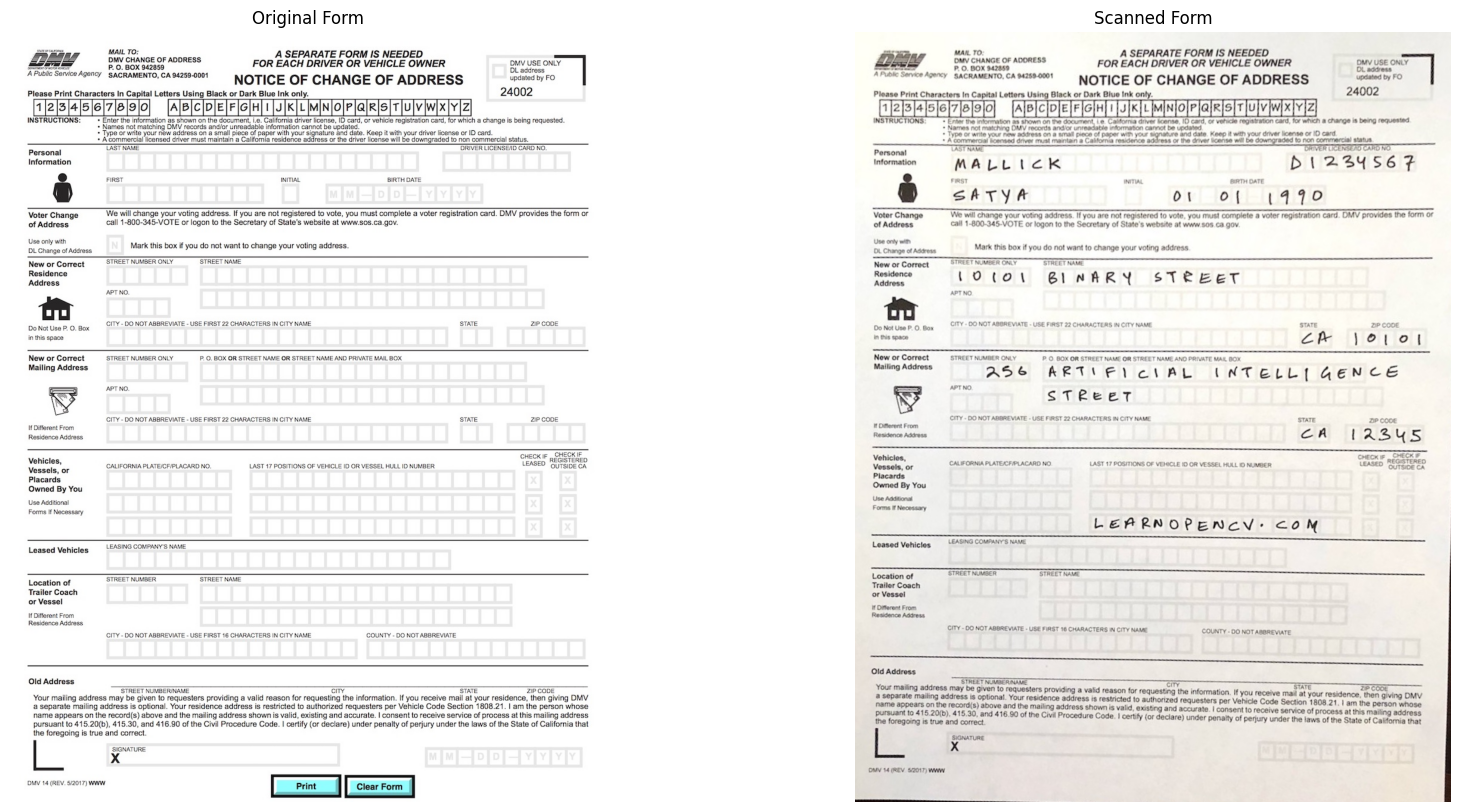

In [ ]:
# Use homography to warp image for alignment
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height)) # im2=target image wraping here with width and height to img 1 refrence image

# Display results
plt.figure(figsize=[20,10]);
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original Form");
plt.subplot(122); plt.imshow(im2_reg); plt.axis('off'); plt.title("Scanned Form");

## 🔗 Navigation

[![⬅️ Module 07](https://img.shields.io/badge/Module-07-blue?style=for-the-badge&logo=github)](https://github.com/Adityeah18/opencv/tree/main/07)
&nbsp;&nbsp;&nbsp;
[![➡️ Module 09](https://img.shields.io/badge/Module-09-blue?style=for-the-badge&logo=github)](https://github.com/Adityeah18/opencv/tree/main/09)
